<a href="https://colab.research.google.com/github/yonghyuk0120/CNN_Study/blob/master/model/VGGNet(TF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                                                                ↑↑↑↑↑↑
                                        위의 Open in Colab 을 누르면 훨씬 가독성 있게 볼 수 있습니다.

# 패키지 불러오기

In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 98 kB 5.4 MB/s 
     |████████████████████████████████| 37.1 MB 1.3 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import sklearn
import albumentations as A

# VGG16 구현

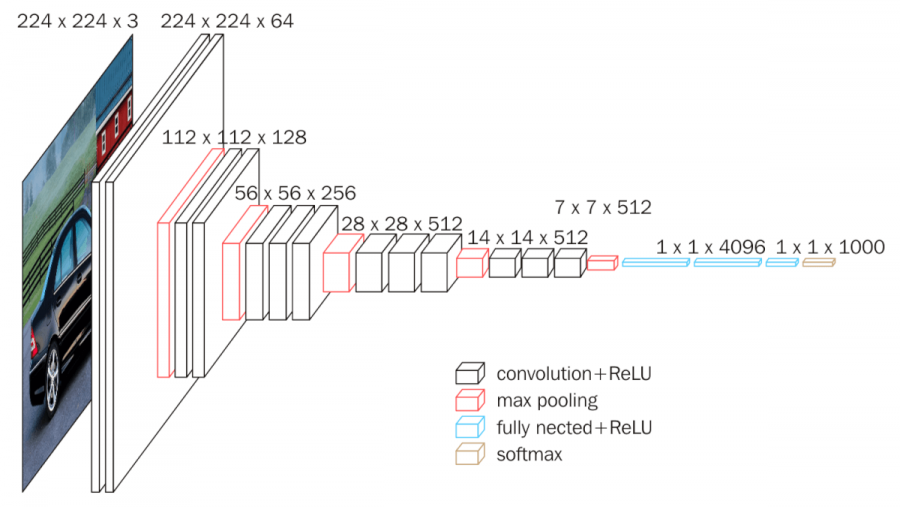

* VGGNet 부터 CNN모델들이 깊어지기 시작 이는, 모든 필터 사이즈를 3x3으로 설정하여 가중치를 크게 줄였기 때문.
* Receptive Field : 3x3 필터가 2개 연속으로 나오면 사실상 5x5 필터와 같은 범위에서 feature를 뽑아 내는 것이고, 3x3 필터가 3개 연속으로 나오면 사실상 7x7필터와 같은 범위를 다룰 수 있다(아래 그림). 이 방법으로 오히려 가중치수를 크게 줄일 수 있었으며, VGGnet 등장부터 모델들이 깊어지기 시작했다.
* conv를 2번 혹은 3번을 적용 하고, pooling하여 feature map을 만들어낸다. 이 때, 2x2로 feature map 크기를 2배로 줄이지만, 동시에 채널을 2배로 늘리는 방식을 채택.
* 구조가 feature map 기준으로 블럭 단위로 이루어졌다고 보고 block 단위 구현해보기
* 이미지에 관해서는 multi-scale을 하였음. [Smin, Smax]를 정해서, 여기서는 256~ 512 단위로 랜덤으로 바꾸어주고, 다음으로 224x224로 랜덤 crop을 하였음. 이런 방식을 sacle jittering 이라 불렀음. 다만, 스피드를 이유로 S = 384사이즈의 single-scale로 pre-train을 한 후 fine-tuning을 하였음. 

* 그 외 디테일한 내용 
    * SGD(mini batch 사용)
    * 배치 사이즈는 256, 모멘텀 0.9, dropout 0.5
    * weight decay(L2 penalty 이용) 5*10^-4 = 0.0005
    * learning rate 초기 치는 0.01 , 정확도 향상이 멈추면 1/10
    * 논문에서는 3번 멈춘 74 epoch
    * bias는 초기값 0
    * 가중치 초기화 부분에서 사전 훈련을 사용했지만 이 후 논문에서 worth noting 한 것을 확인 따라서 다루지 않겠음.
    * RGB colour shift >> PCA 이용
    * flatten 대신 gloabal average pooling 사용

 

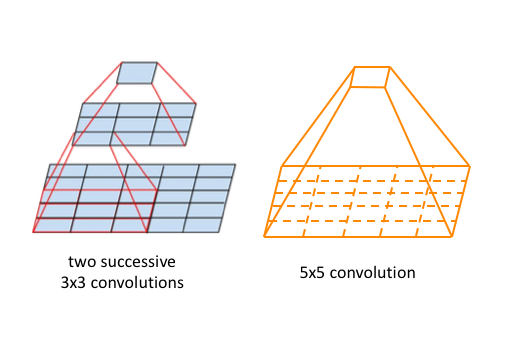

## 블럭 구현

In [ ]:
def block(input_tensor, filters, kernel_size, repeats=2):
    x = input_tensor
    for i in range(repeats):
        x = Conv2D(filters= filters, kernel_size = kernel_size, activation = 'relu', padding ='same')(x)

    x = MaxPooling2D((2,2), strides = 2)(x)

    return x

In [ ]:
input_tensor = Input(shape=(224, 224, 3))
x = block(input_tensor=input_tensor, filters=64, kernel_size=(3, 3), repeats=3)

conv1= Model(inputs=input_tensor, outputs=x)
conv1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


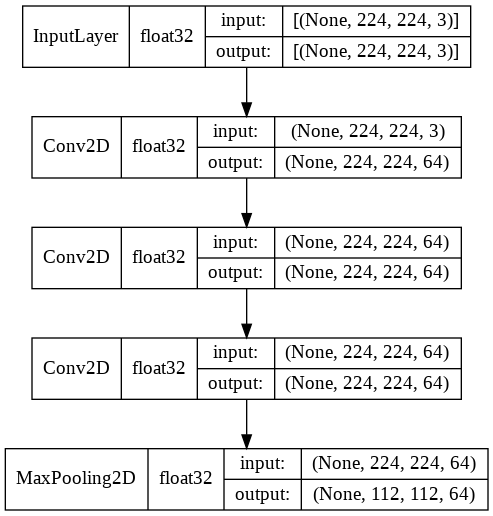

In [ ]:
#구현 확인
tf.keras.utils.plot_model(conv1, show_layer_names=False, show_shapes=True, show_dtype=True)

## VGG16 모델 구현

In [ ]:
input_tensor = Input(shape=(224, 224, 3), name='Input Tensor')

#block 1
block1 = block(input_tensor, filters=64, kernel_size=(3, 3), repeats=2)
#block 2
block2 = block(block1, filters=64, kernel_size=(3, 3), repeats=2)

#block 3
block3 = block(block2, filters=64, kernel_size=(3, 3), repeats=3)

#block 4
block4 = block(block3, filters=64, kernel_size=(3, 3), repeats=3)

#block 5
block5 = block(block4, filters=64, kernel_size=(3, 3), repeats=3)


# GlobalAveragePooling
x = GlobalAveragePooling2D()(block5)
x = Dropout(0.5)(x)
#원래는 4096으로 해야하지만 이미지를 CIFAR 10을 사용할 것이기 때문에 units 120
x = Dense(units = 120, activation = 'relu')(x)
x = Dropout(0.5)(x)


output = Dense(units = 10, activation = 'softmax')(x)
model = Model(inputs=input_tensor, outputs=output)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Tensor (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0   

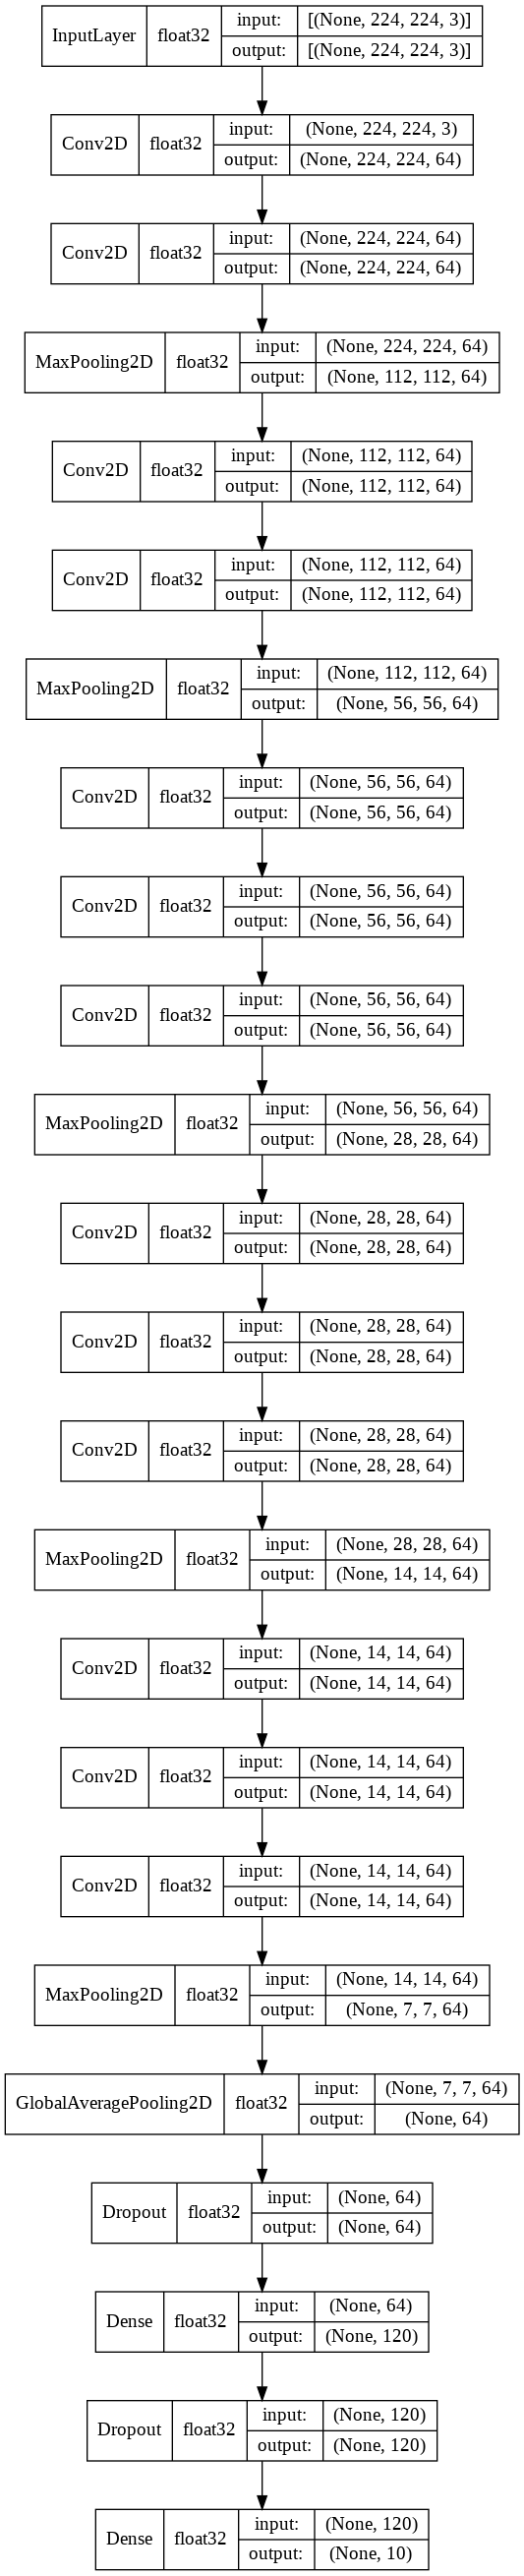

In [ ]:
tf.keras.utils.plot_model(model, show_layer_names=False, show_shapes=True, show_dtype=True)

# CIFAR10 전처리


In [ ]:
import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

In [ ]:
(tr_im, tr_lb), (test_images, t_lb) = cifar10.load_data()

# 웟핫 인코딩
tr_oh_lb = to_categorical(tr_lb)
test_labels = to_categorical(t_lb)

# 훈련 세트 분할
train_images,  val_images , train_labels, val_labels = train_test_split(tr_im,tr_oh_lb, test_size=0.2 ,random_state = 403)


print(train_images.shape, train_labels.shape,val_images.shape, val_labels.shape,test_images.shape, test_labels.shape)

170508288/170498071 [==============================] - 2s 0us/step
(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)


## Sequence Dateset 생성

모델에 배치단위 입력으로 들어가고, data augmentation 구현

In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.densenet import preprocess_input as dense_pr_input
class DataSet(Sequence): 
    def __init__(self, images_array, labels, batch_size,  augmentor=None, shuffle=False, pre_func =None):
        self.images_array = images_array
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor= augmentor
        self.pre_func = pre_func
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            self.on_epoch_end()
            pass

    def __len__(self):
        return int(np.ceil(len(self.labels) / self.batch_size))

    def __getitem__(self, index):
        pre_im_batch = self.images_array[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]

        #multiscale 구현
        random_n = np.random.randint(256,513)

        image_batch = np.zeros((pre_im_batch.shape[0],224,224, 3), dtype = 'float32')

        for i in range(pre_im_batch.shape[0]):
            image = cv2.resize(pre_im_batch[i], (random_n,random_n) )

            if self.augmentor is not None:
                image = self.augmentor(image=image)['image'] 

            if self.pre_func is not None:
                for func in self.pre_func:
                    image = func(image)

            image = cv2.resize(image, (224,224) )

            image_batch[i] = image
                
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        self.images_array, self.labels = sklearn.utils.shuffle(self.images_array, self.labels)


## augmentation 구현. RGBshift,HorizontalFlip, randomcrop + multiscale


In [ ]:
# 증강

augmentor = A.Compose([
    A.RandomCrop(height=224, width=224, p=1),
    A.HorizontalFlip(),
    A.FancyPCA()
])



train_dataset = DataSet(train_images, train_labels, batch_size=64, augmentor=augmentor, shuffle=True )
val_dataset = DataSet(val_images, val_labels, batch_size=64, augmentor=None, shuffle=False)


In [ ]:
# 내용 확인
images_batch = next(iter(train_dataset))[0]
labels_batch = next(iter(train_dataset))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0])

(64, 224, 224, 3) (64, 10)
[[[ 52.  42.  18.]
  [ 52.  42.  18.]
  [ 52.  42.  18.]
  ...
  [ 41.  34.  17.]
  [ 41.  34.  18.]
  [ 42.  35.  19.]]

 [[ 53.  42.  19.]
  [ 53.  42.  18.]
  [ 53.  42.  18.]
  ...
  [ 41.  34.  18.]
  [ 41.  35.  18.]
  [ 42.  35.  19.]]

 [[ 53.  43.  19.]
  [ 53.  43.  19.]
  [ 53.  43.  19.]
  ...
  [ 41.  34.  18.]
  [ 42.  35.  19.]
  [ 42.  35.  19.]]

 ...

 [[102.  93.  64.]
  [102.  93.  64.]
  [101.  93.  64.]
  ...
  [ 73.  63.  32.]
  [ 75.  65.  34.]
  [ 76.  67.  35.]]

 [[103.  94.  65.]
  [102.  93.  65.]
  [101.  93.  64.]
  ...
  [ 74.  65.  33.]
  [ 76.  66.  35.]
  [ 77.  68.  36.]]

 [[103.  94.  66.]
  [102.  94.  65.]
  [102.  94.  65.]
  ...
  [ 76.  66.  35.]
  [ 77.  68.  36.]
  [ 79.  69.  38.]]]


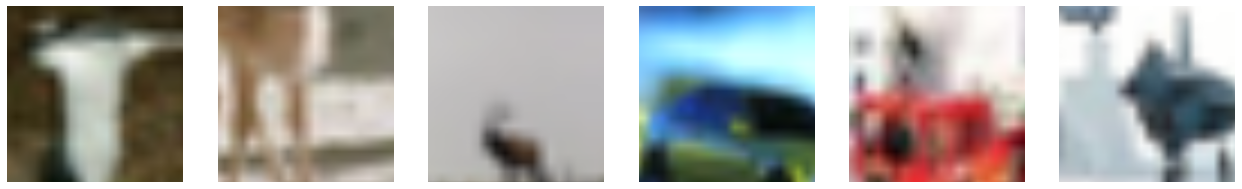

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

def show_grid_images(images_batch, ncols=4):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        # image_batch는 float형이므로 int형으로 변경하여 이미지 시각화
        axs[i].imshow(np.array(images_batch[i], dtype='int32'))
        axs[i].axis('off')

show_grid_images(images_batch, ncols=6)

#원본이 작아서 어쩔 수 없이 아래와 같이 나온다..

In [ ]:
#dense_pr_input을 이용하여 스캐일링
train_dataset = DataSet(train_images, train_labels, batch_size=64, augmentor=augmentor, shuffle=True, pre_func = [dense_pr_input]) 
val_dataset = DataSet(val_images, val_labels, batch_size=64, augmentor=None, shuffle=False, pre_func = [dense_pr_input])

# fit 및 평가

In [ ]:
model.compile(optimizer=SGD(lr=0.01, momentum= 0.09,decay =0.0005 ), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# 3번 validation error 가 개선되지 않으면 lr에 0.1곱함
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='min', verbose=1)
# 3번 동안 개선이 없다면 조기종료
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

In [ ]:
history = model.fit(train_dataset, epochs=30, 
                    validation_data=val_dataset ,
                   callbacks=([rlr_cb, ely_cb]), verbose=1)

Epoch 1/30
625/625 [==============================] - 270s 401ms/step - loss: 2.3020 - accuracy: 0.1104 - val_loss: 2.3003 - val_accuracy: 0.1391
Epoch 2/30
625/625 [==============================] - 258s 412ms/step - loss: 2.2969 - accuracy: 0.1308 - val_loss: 2.2891 - val_accuracy: 0.1691
Epoch 3/30
625/625 [==============================] - 257s 411ms/step - loss: 2.2722 - accuracy: 0.1453 - val_loss: 2.2060 - val_accuracy: 0.1652
Epoch 4/30
625/625 [==============================] - 257s 411ms/step - loss: 2.2041 - accuracy: 0.1627 - val_loss: 2.1361 - val_accuracy: 0.1714
Epoch 5/30
625/625 [==============================] - 258s 412ms/step - loss: 2.1573 - accuracy: 0.1694 - val_loss: 2.1170 - val_accuracy: 0.1718
Epoch 6/30
625/625 [==============================] - 258s 412ms/step - loss: 2.1355 - accuracy: 0.1775 - val_loss: 2.0805 - val_accuracy: 0.1904
Epoch 7/30
625/625 [==============================] - 256s 409ms/step - loss: 2.1209 - accuracy: 0.1779 - val_loss: 2.0572 -

In [ ]:
# 평가
test_dataset = DataSet(test_images, test_labels, batch_size=64, pre_func = [dense_pr_input])
print(model.evaluate(test_dataset))


157/157 [==============================] - 27s 173ms/step - loss: 1.9877 - accuracy: 0.2171
[1.9877409934997559, 0.21709999442100525]
